### Hybrid Variational Neural Network for Fano fitting (Quantum-Classical Variational Neural Network)

<p>Perform a regression to fit a Fano resonance with Pennylane framework</p>

<p> Let's fit a <a href="https://en.wikipedia.org/wiki/Fano_resonance">Fano resonance</a>, this signal appears on superconducting resonators when photons<sup><a href="https://arxiv.org/abs/2207.03829">[1]</a></sup> interact with spins at low temperatures (from 4K to 10mK in a dilution refrigerator)</p>

#### References:

> https://arxiv.org/abs/2207.03829
>
> https://qiskit.org/textbook/ch-applications/vqe-molecules.html

In [1]:
import tensorflow as tf

from qiskit import QuantumCircuit, Aer, execute
from math import asin, sqrt, ceil
from qiskit.opflow import Z, CircuitStateFn, StateFn, PauliExpectation, PauliSumOp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Layer, ReLU
import logging
import warnings

warnings.filterwarnings('ignore')
logging.getLogger('tensorflow').setLevel(logging.ERROR)

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [2]:
tf.executing_eagerly()

True

In [3]:
fano_data = pd.read_csv("./datasets/signal_080_peak_1_fano_adjust.csv")

In [4]:
def func_fano(x, xc, w, q, y0):
    y = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)
    return y

def scale(arr, lvalue = -np.pi, rvalue = np.pi):
    return np.interp(arr, (arr.min(), arr.max()), (lvalue, rvalue))

def remove_outlier(df_in, col_name, quartiles, rng_arr):
    q1 = df_in[col_name].quantile(quartiles[0])
    q3 = df_in[col_name].quantile(quartiles[1])
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-rng_arr[0]*iqr
    fence_high = q3+rng_arr[1]*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [5]:
def smooth(data):
    #return data
    #return scipy.ndimage.gaussian_filter(data, sigma=30, mode='reflect', truncate=18.0)
    
    return gaussian_filter(data, sigma=15, mode='reflect', truncate=18.0)
    #return scipy.ndimage.gaussian_filter(data, sigma=15, mode='reflect', truncate=15.0)

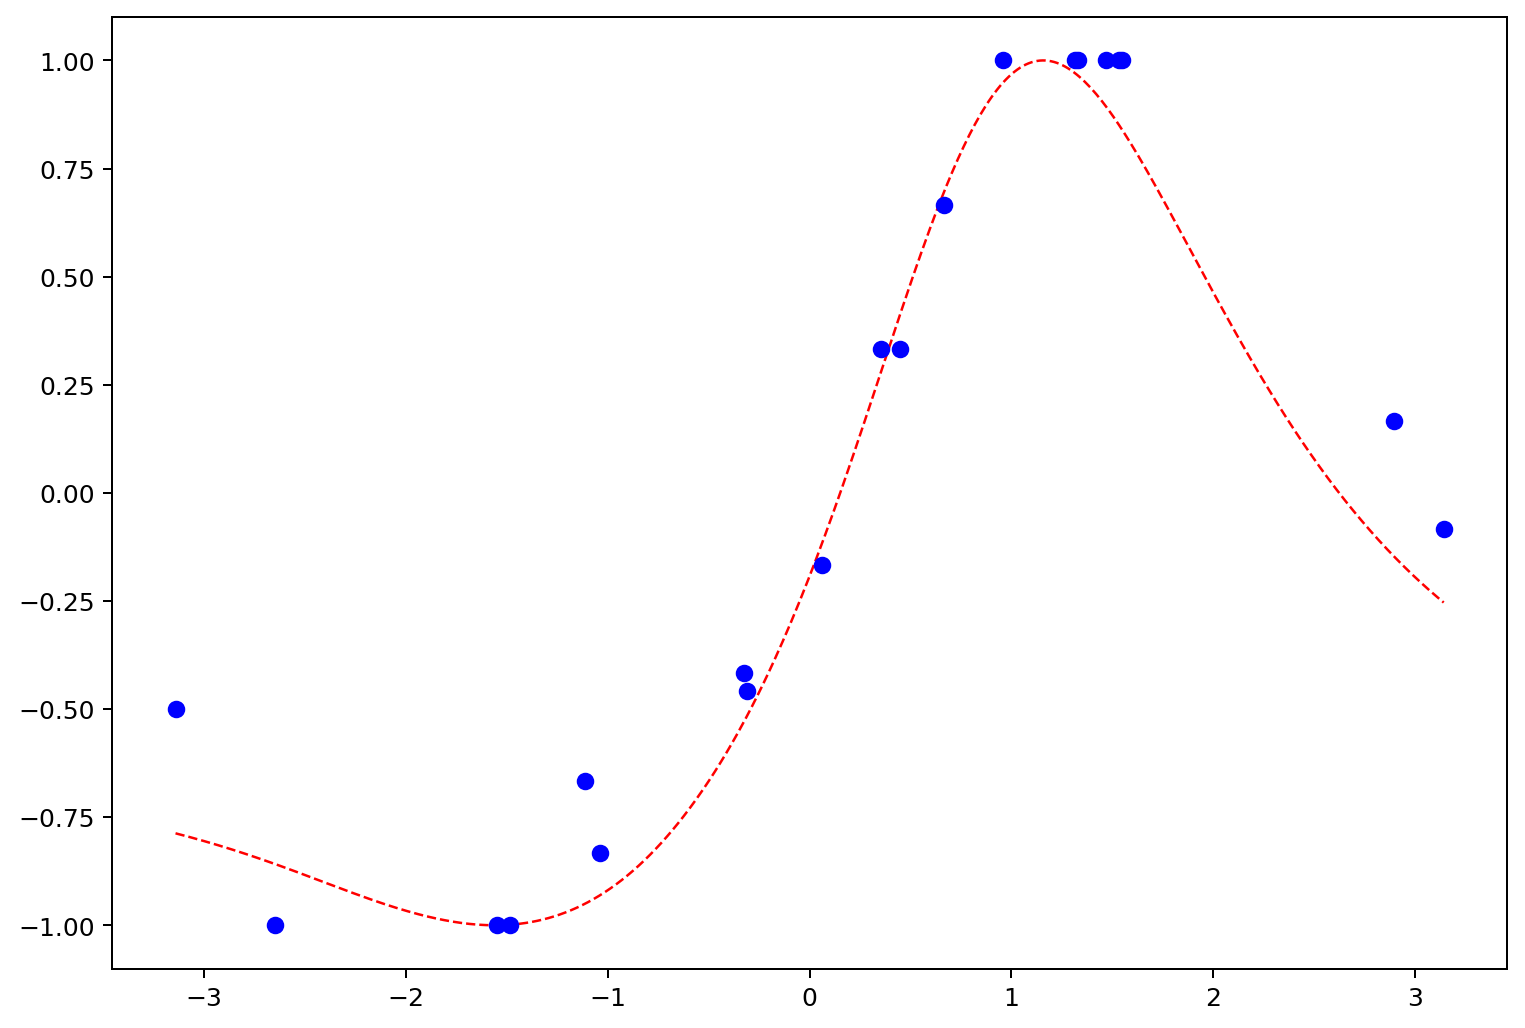

In [6]:
num_samples = 20
eps = 0.2
lb, ub = -1, 1

y0 = fano_data["y0"].values[0]
A = fano_data["A"].values[0]
xc = fano_data["xc"].values[0]
q = fano_data["q"].values[0]
w = fano_data["w"].values[0]

f = lambda x: func_fano(x, xc, w, q, y0)

X_ = fano_data["signal_original_x"].values.reshape(-1,1)

# Create Gaussian distribution (mean = 0, std = 1)
std_scaler = StandardScaler()
std_scaler.fit(X_)
X_ = std_scaler.transform(X_)

#y_ = f(X_)

y_ = fano_data["signal_original_y"].values

# select a better range of data to fit
rng = range(250,700)

X_ = X_.take(rng, axis=0)
y_ = y_.take(rng, axis=0)

# random indices for points selection
#indices = sorted(np.random.choice(range(X_.shape[0]), num_samples, replace=False))

#indices = np.array([19,  40, 156, 159, 173, 175, 191, 207, 213, 253, 358, 359, 448, 543, 559, 613, 651, 657, 737, 754])
indices = [22, 54, 125, 129, 153, 158, 204, 205, 229, 248, 254, 268, 287, 310, 311, 320, 324, 325, 412, 428]

XX = X_[indices].reshape(-1,1)
yy = y_[indices].reshape(-1,1)

#df = pd.DataFrame(zip(X[:,0].flatten().tolist(), y[:,0].flatten().tolist()), columns = ["X", "y"])
#new_df = remove_outlier(df, "y", [0.25, 0.75], [0.05, 0.05])
#X = new_df["X"].values.reshape(-1,1)
#y = new_df["y"].values.reshape(-1,1)

yy = detrend(yy)

#XX = scale(XX, 0, 1)
XX = scale(XX) # from -pi to pi
yy = scale(yy, -1, 1)

#X_ = scale(X_, 0, 1)
X_ = scale(X_) # from -pi to pi
y_ = scale(y_, -1, 1)

plt.figure(num = "Fano adjust data", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(X_, y_, "r--", label='Tx signal', linewidth = 1)
plt.plot(XX, yy, "bo", label = 'Points to fit')
plt.show()

In [7]:
def prob_to_angle(prob):
    return 2*asin(sqrt(prob))

In [8]:
def quantum_layer2(initial_parameters, num_qubits):
   
    simulator = Aer.get_backend('qasm_simulator')
    shots = 4096

    expectations = []
    
    for i in range(len(initial_parameters)):
        
        quantumCircuit = QuantumCircuit(num_qubits)

        quantumCircuit.h(range(num_qubits))
    
        angles = initial_parameters[i]
        
        for j in range(len(angles)):
            #quantumCircuit.ry(prob_to_angle(float(angles[j])), j)
            #quantumCircuit.ry(angles[j] * np.pi, j)
            quantumCircuit.ry(angles[j], j)
   
        quantumCircuit.measure_all()

        job = execute(quantumCircuit, backend=simulator, shots=shots)
        result = job.result().get_counts(quantumCircuit)

        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)

        # Compute probabilities for each state
        probabilities = counts / shots
        
        # Get state expectation
        expectation_value = np.sum(states * probabilities)
        
        expectations.append(expectation_value)

    diff = num_qubits - len(expectations)
    
    if diff > 0:
        for _ in range(diff):
            expectations.append(0)
            
    return np.array(expectations)

In [9]:
def quantum_layer(initial_parameters, num_qubits):

    expectations = []
    
    for i in range(len(initial_parameters)):
        
        quantumCircuit = QuantumCircuit(num_qubits)

        quantumCircuit.h(range(num_qubits))
    
        angles = initial_parameters[i]
        
        for j in range(len(angles)):
            #quantumCircuit.ry(prob_to_angle(float(angles[j])), j)
            #quantumCircuit.ry(angles[j] * np.pi, j)
            quantumCircuit.ry(angles[j], j)

        #quantumCircuit.h(range(num_qubits))
 
        #operator = Z
        #for _ in range(num_qubits - 1):
        #    operator @= Z
          
        psi = StateFn(quantumCircuit)
        #psi = CircuitStateFn(quantumCircuit)
        #expectation_value = psi.adjoint().compose(operator).compose(psi).eval() 
               
        #expectation_value = (~psi @ operator @ psi).eval()

        #expectation_value = PauliExpectation().convert(expectation_value).eval()
        
        H1 = StateFn(PauliSumOp.from_list([("Z", 1.0), ("X", 1.0)]))        
        expectation_value = (~H1 @ psi).eval()

        expectations.append(expectation_value)
 
    diff = num_qubits - len(expectations)
    
    if diff > 0:
        for _ in range(diff):
            expectations.append(0j)
    
    return expectations

In [10]:
class Linear(Layer):
    
    def __init__(self, output_size, batch_size = 10, units = 1, input_dim=1, num_qubits = 1, **kwargs):
        
        super(Linear, self).__init__(**kwargs)
        
        #self.threshold = 0.1
        self.num_qubits = num_qubits
        self.output_size = output_size
        self.dense = tf.keras.layers.Dense(num_qubits, name='internal_dense')
        self.w = self.add_weight(
            shape=(input_dim, units), initializer="random_normal", trainable=True
        )
        
        self.b = self.add_weight(shape=(units,), initializer="zeros", trainable=True)

    def build(self, input_shape): 
        self.input_size = input_shape[1]        
        self.w = self.add_weight(shape=(self.input_size, self.output_size), initializer='random_normal', trainable=True)
        super(Linear, self).build(input_shape)
        
    def get_config(self):
        config = super(Linear, self).get_config()
        return config

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        shape_a, shape_b = input_shape
        return [shape_a, shape_b]
    
    def call(self, inputs):
        
        if (tf.executing_eagerly()):
            
            final_output = []
        
            for i in range(inputs.shape[0]):
                pred = quantum_layer(inputs.numpy(), self.num_qubits)
                final_output.append(list(pred))
            
            #out_layer = tf.keras.layers.Dense(self.num_qubits, activation='relu')
            
            return tf.convert_to_tensor(final_output)
        
        #return tf.sigmoid(tf.add(tf.matmul(inputs, self.w**2), self.b))
        #x = self.dense(inputs)
        return inputs

In [11]:
n_qubits = 1

In [12]:
def sequential_model():

    layers_arr = []
    layers_arr.append(Dense(n_qubits, activation = 'linear', input_shape = [1], name = "dense1"))
    layers_arr.append(Linear(output_size = n_qubits, units = 1, input_dim = n_qubits, num_qubits = n_qubits, name = "quantum1"))
    #layers_arr.append(Dense(1, activation="linear", name = "dense2"))   
    layers_arr.append(Dense(1, name ="dense3"))

    return Sequential(layers_arr)

In [13]:
model = sequential_model()

#optimizer = Adam(learning_rate=0.01)
optimizer = SGD(learning_rate=0.01)

#model.compile(loss='mse', optimizer = optimizer, metrics = ['mae', 'mse', 'acc'], run_eagerly=True)
model.compile(optimizer, loss='mse', metrics=["accuracy"], run_eagerly=True)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 1)                 2         
_________________________________________________________________
quantum1 (Linear)            (None, 1)                 2         
_________________________________________________________________
dense3 (Dense)               (None, 1)                 2         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(XX, yy, epochs = 50, batch_size=n_qubits, validation_split = 0.25)

#history = model.fit(XX, yy, epochs = 50, batch_size=n_qubits, validation_split = 0.25)

Epoch 1/50
15/15 [==============================] - 0s 14ms/step - loss: 0.2841 - accuracy: 0.0000e+00 - val_loss: 0.4608 - val_accuracy: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 0s 13ms/step - loss: 0.2288 - accuracy: 0.0000e+00 - val_loss: 0.5143 - val_accuracy: 0.0000e+00
Epoch 3/50
15/15 [==============================] - 0s 13ms/step - loss: 0.1945 - accuracy: 0.0000e+00 - val_loss: 0.5731 - val_accuracy: 0.0000e+00
Epoch 4/50
15/15 [==============================] - 0s 13ms/step - loss: 0.1724 - accuracy: 0.0667 - val_loss: 0.6312 - val_accuracy: 0.0000e+00
Epoch 5/50
15/15 [==============================] - 0s 13ms/step - loss: 0.1589 - accuracy: 0.0667 - val_loss: 0.6714 - val_accuracy: 0.0000e+00
Epoch 6/50
15/15 [==============================] - 0s 14ms/step - loss: 0.1492 - accuracy: 0.0667 - val_loss: 0.7205 - val_accuracy: 0.0000e+00
Epoch 7/50
15/15 [==============================] - 0s 13ms/step - loss: 0.1443 - accuracy: 0.0667 - val_loss: 0.7486 

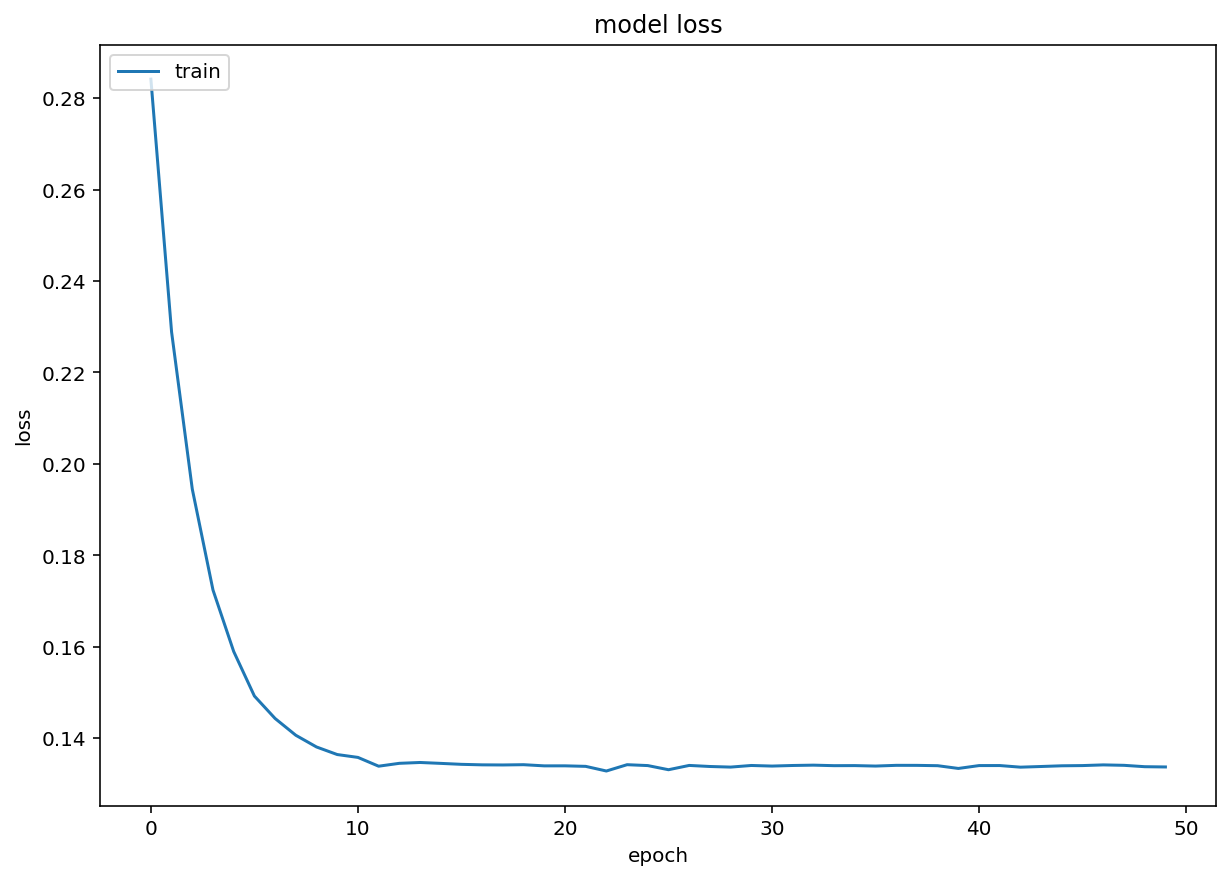

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [17]:
def split_batch_predict(data, num_qubits, model):
    
    splitted_X = None

    if num_qubits > 1:
        num_sections = ceil(X_.shape[0] / num_qubits)
        splitted_X = np.array_split(data.flatten(), num_sections)
    else:
        splitted_X = data

    y_prediction = []

    for arr in splitted_X:
        pred = model.predict(arr)
        y_prediction.append(pred.tolist())
    
    return np.array(y_prediction)

In [18]:
y_predict = split_batch_predict(X_, n_qubits, model)

In [19]:
y_predict_smooth = smooth(y_predict)

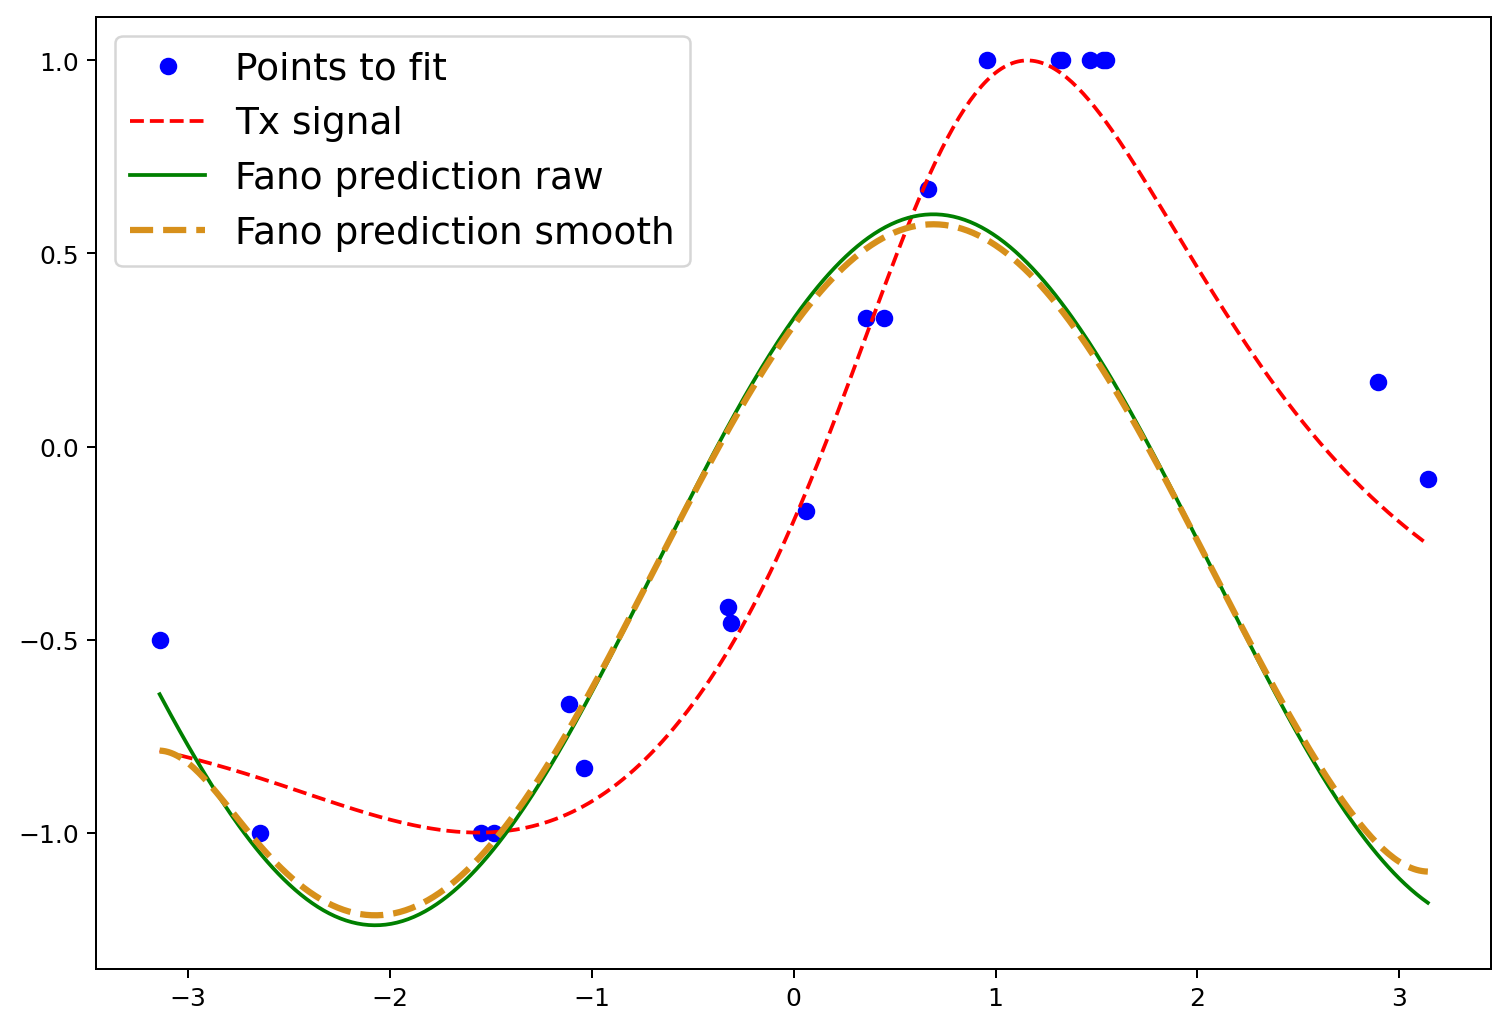

In [20]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(XX, yy, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot prediction
plt.plot(X_, y_predict.flatten(), "g-", label = 'Fano prediction raw')
plt.plot(X_, y_predict_smooth.flatten(), "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [21]:
print("Score: %.10f" % r2_score(y_, y_predict.flatten()))

Score: 0.4799219654


In [22]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright